# Exploration of 2023 Annotations


* Data annotated by Simon Geikie July/August 2023
* Data sourced for Ordnance Survey July/August 2023

| **Key**                     | **Meaning**                                                             |
|-----------------------------|-------------------------------------------------------------------------|
| Present (2023)           | Present in OS data \| Present in the 2023 AP \| Present in 2014 AP      |
| Absent (2023)            | Present in OS data \| Absent in the 2023 AP \| Absent in 2014 AP        |
| Absent (Present 2014)    | Absent in OS data \| Absent in the 2023 AP \| Present in 2014 AP        |
| Obscured (shadows and vegetation)    | Obscured by trees, scrub or long grass.                                 |
| Urban                    | A mask created to simplify the detection of walls to only the open landscape |
| Absent (Present 1950)    | Absent in OS data \| Present only on 1950's basemap                     |

In [1]:
# load libraries 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection

In [33]:
# load data
walls = gpd.read_file("../content/labels/Walls.shp")
walls.crs

<Derived Projected CRS: PROJCS["OSGB36_British_National_Grid",GEOGCS["GCS_ ...>
Name: OSGB36_British_National_Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

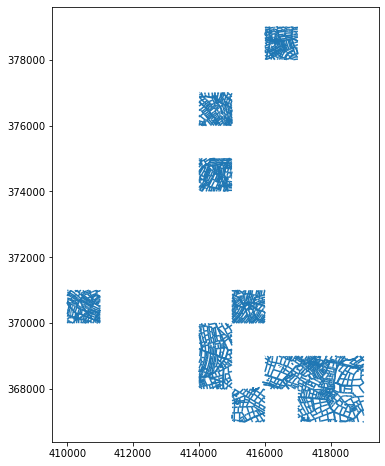

In [34]:
# take a look
walls.plot(figsize=(8,8))

In [35]:
walls.head(1)

,osid,toid,Label_2023,theme,istidal,changetype,ishistoric,isobscured,descriptio,versiondat,...,capturespe,geometry_e,descript_2,versionava,firstdigit,descript_3,versiona_1,FID_1,Shape_Leng,geometry
0,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."


In [36]:
walls['Label_2023'].unique()

array(['Urban', 'Present (2023)', 'Obscured (shadows and vegetation)',
       'Absent (2023)', 'Absent (Present 2014)', 'Absent (Present 1950)'],
      dtype=object)

In [37]:
walls['length'] = walls.length

In [42]:
wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)
wall_t = wall_t.T.reset_index()
wall_t

C:\Users\alexad\AppData\Local\Temp\ipykernel_11500\3379901016.py:1: FutureWarning: The provided callable <function sum at 0x0000020C2BB40C10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)


,Label_2023,length
0,Absent (2023),1775.155251
1,Absent (Present 1950),33302.576547
2,Absent (Present 2014),1950.483098
3,Obscured (shadows and vegetation),40182.210978
4,Present (2023),202160.536977
5,Urban,44043.508570


In [43]:
data = ['Absent', 'Absent', 'Absent', 'Present', 'Present', 'Urban' ]
wall_t['presence'] = data
wall_t

,Label_2023,length,presence
0,Absent (2023),1775.155251,Absent
1,Absent (Present 1950),33302.576547,Absent
2,Absent (Present 2014),1950.483098,Absent
3,Obscured (shadows and vegetation),40182.210978,Present
4,Present (2023),202160.536977,Present
5,Urban,44043.508570,Urban


In [44]:
# for graph only
wall_t = wall_t.drop(index=(5))
pivot = pd.pivot_table(data=wall_t, index=['presence'], columns=['Label_2023'], values='length')

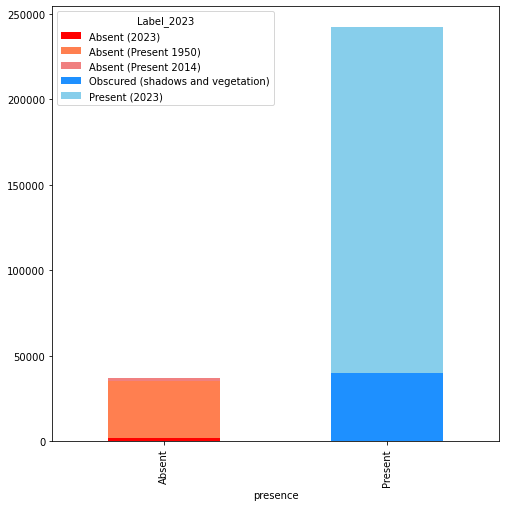

In [66]:
color = ['red', 'coral', 'lightcoral', 'dodgerblue', 'skyblue']
ax = pivot.plot.bar(stacked=True, figsize=(8,8), color=color)

In [16]:
from rasterio.crs import CRS
from pyproj import Transformer

# Load the shapefile
gdf = gpd.read_file("../content/predictions/hough_lines.shp")


# Define a transformer to convert from the current CRS to EPSG:27700 (British National Grid)
transformer = Transformer.from_crs(gdf.crs, "EPSG:27700")

# Apply the transformation to the geometry column
gdf['geometry'] = gdf['geometry'].apply(lambda geom: [transformer.transform(x, y) for x, y in geom.coords])

# Print the first few rows of the transformed GeoDataFrame
print(gdf.head())

# Reproject the GeoDataFrame to match the CRS of the GeoTIFF image
#gdf = gpd.GeoDataFrame.from_features(gdf, crs="EPSG:27700")  # Replace EPSG code with the correct one for your GeoTIFF CRS

# Save the reprojected GeoDataFrame to a new shapefile
#gdf.to_file("../content/predictions/reprojected_shapefile.shp")

# Check the CRS of the reprojected shapefile
#print(gdf.crs)

   FID                              geometry
0    0  [(2059.0, 2051.0), (1909.0, 1945.0)]
1    1      [(606.0, 714.0), (656.0, 497.0)]
2    2  [(1857.0, 2169.0), (1952.0, 2063.0)]
3    3     [(1134.0, 151.0), (1153.0, 15.0)]
4    4      [(949.0, 804.0), (979.0, 629.0)]


/tmp/ipykernel_3213/389215823.py:12: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: [transformer.transform(x, y) for x, y in geom.coords])


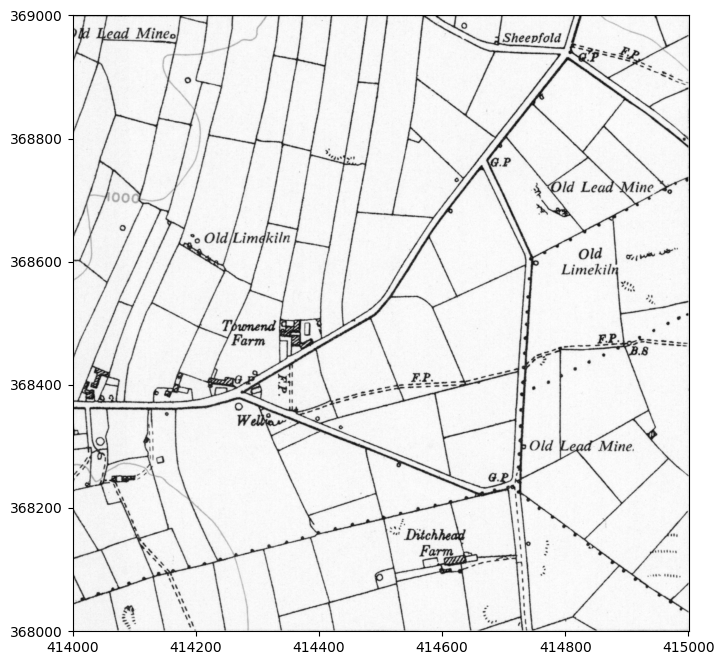

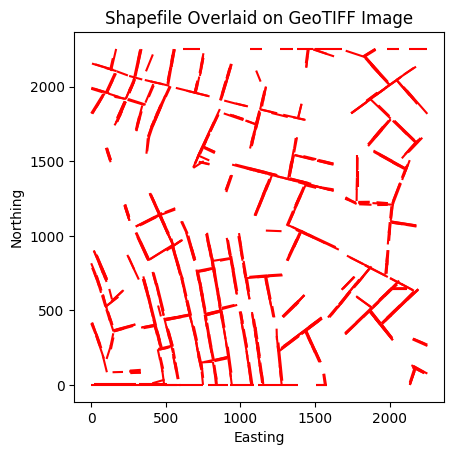

In [7]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# Paths to GeoTIFF and shapefile
tif_path = "../content/tifs/1k_tifs/SK1468.TIF"
shp_path = "../content/predictions/reprojected_shapefile.shp" 

# Load GeoTIFF image
with rasterio.open(tif_path) as src:
    img = src.read(1)  # Read the first band (assuming it's a single-band image)
    extent = rasterio.plot.plotting_extent(src)

# Load shapefile
shapefile = gpd.read_file(shp_path)

# Plot GeoTIFF image
plt.figure(figsize=(10, 8))
show(img, extent=extent, cmap='gray')

# Plot shapefile over the image
shapefile.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

# Set plot title and labels
plt.title('Shapefile Overlaid on GeoTIFF Image')
plt.xlabel('Easting')
plt.ylabel('Northing')

# Show the plot
plt.show()
